In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
from scipy.optimize import curve_fit
from scipy.misc import derivative
from iminuit import Minuit, describe, Struct
from scipy.integrate import quad
import pandas as pd
import numpy as np
from scipy.special import gamma, hyp2f1
from IPython.core.debugger import set_trace
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import pickle

In [2]:
# for python 3 use this caching function
# This tool will cache to memory, which is non persistent but fast
#from functools import lru_cache

# for python 2 use this caching function
# This tool will cache to disk, which adds persistence but is slower
from pyik.performance import cached, cached_at

In [3]:
# settings / constants

scintillator_slab_geometry = (0.2, 0.2) # 2 dimensional geometry in meters
scintillator_slab_thickness = 0.028
current_setup_distance = 2*scintillator_slab_thickness
np.random.seed(42)

number_of_grid_steps = 10


## Get Data from Excel file

In [4]:
# extract data from excel

path_to_excel_file = "C:/Users/Hendrik/OneDrive/active_sync_storage/Uni/MPIK/Bachelor/Teilchenwelt_detector/rate_with_distance_measurment.xlsx"
measured_data = pd.read_excel(path_to_excel_file)
measured_data = measured_data.sort_values(by=['distance [m]'])
measured_data = measured_data.reset_index(drop=True)

# get our starting point as well as the rate to start with

minimum_distance = measured_data["distance [m]"].min()
maximum_distance = measured_data["distance [m]"].max()
rows_with_minimum = measured_data.loc[measured_data["distance [m]"] == minimum_distance]
lowest_distance_avg_rate = rows_with_minimum["rate [Hz]"].mean()

In [5]:
measured_data

,date,start time,distance [m],d distance [m],DAQ,time [s],count [1],d count [1],rate [Hz],d rate [Hz],Unnamed: 10,Scintillator eff,rate corrected [Hz],d rate corrected [Hz],rate orig,d rate orig
0,2017-11-23,14:35:00,0.056,0.004,NIM,1200,4850,69.641941,4.128226,0.060020,NaN,0.979032,4.128226,0.060020,4.041667,0.058035
1,2017-11-27,15:00:00,0.056,0.004,NIM,1200,4891,69.935685,4.163124,0.060280,NaN,NaN,4.163124,0.060280,4.075833,0.058280
2,2017-11-27,15:25:00,0.084,0.004,NIM,1200,4059,63.710282,3.454942,0.054798,NaN,NaN,3.454942,0.054798,3.382500,0.053092
3,2017-11-27,12:50:00,0.104,0.004,NIM,1200,3682,60.679486,3.134047,0.052141,NaN,NaN,3.134047,0.052141,3.068333,0.050566
4,2017-11-23,15:05:00,0.122,0.004,NIM,1200,3209,56.648036,2.731439,0.048618,NaN,Err up,2.731439,0.048618,2.674167,0.047207
5,2017-11-27,13:10:00,0.170,0.004,NIM,1200,2536,50.358713,2.158594,0.043146,NaN,NaN,2.158594,0.043146,2.113333,0.041966
6,2017-11-23,16:15:00,0.212,0.008,NIM,1200,1936,44.000000,1.647886,0.037640,NaN,0.002232,1.647886,0.037640,1.613333,0.036667
7,2017-11-27,13:32:00,0.234,0.004,NIM,1200,1754,41.880783,1.492971,0.035810,NaN,NaN,1.492971,0.035810,1.461667,0.034901
8,2017-11-23,16:37:00,0.265,0.012,NIM,1200,1519,38.974351,1.292943,0.033305,NaN,Err down,1.292943,0.033305,1.265833,0.032479
9,2017-11-23,17:15:00,0.327,0.016,NIM,1200,1123,33.511192,0.955876,0.028607,NaN,0.00188918,0.955876,0.028607,0.935833,0.027926


## Functions

In [6]:
_Hebbeker_normation = 0.0206865
_Hebbeker_factors = [0.018420759916164563,
                    -0.05409701020482868,
                    0.062345742045134364,
                    0.017889583588494178]

_Hebbeker_formula_assembly = lambda x: (_Hebbeker_factors[0]+
                                        _Hebbeker_factors[1]*np.cos(x)+
                                        _Hebbeker_factors[2]*np.cos(x)+
                                        _Hebbeker_factors[3]*np.cos(2*x))

available_angle_distributions = {"Cos^2": lambda x: np.square(np.cos(x))*4/np.pi,
                                 "Cos^n": lambda x, n=2: np.power(np.cos(x), n)*4/np.pi,
                                 "Biallass&Hebbeker": lambda x, n=123: _Hebbeker_formula_assembly(np.pi-x)/_Hebbeker_normation
                                }


class Numerically_simulated_detector():
    def __init__(self, base_area, angle_distribution_name, number_of_sample_steps):
        self._g_steps = number_of_sample_steps
        self.base_area = base_area
        if angle_distribution_name not in available_angle_distributions:
            raise RunntimeError("The chosen angle distribution {} is not abailable from {}".format(angle_distribution_name, available_angle_distributions.keys()))
        self.angle_distribution_name = angle_distribution_name
        self._additional_angle_distributions_parameters = {'n': 2.}
        
        # generate ticks in the grid
        self._theta_range = np.linspace(0, np.pi/2, self._g_steps)
    
    
    def _calculate_overlapping_detector_area(self, distance, angles):
        base_area = self.base_area
        # in the case that our theta is 0.5*np.pi, the np.tan explodes, this will in turn break the are calculation later on
        # we will replace these values with 0.4999*np.pi
        #np.place(angles, angles == 0.5 * np.pi, 0.4999 * np.pi)

        det1_corners = np.array([[0, 0], [base_area[0], base_area[1]]])

        # calculate the cornres of the second detector on the plane of the first one
        det2_corners = []
        for i in range(2):
            r = np.tan(angles[..., 0]) * distance
            x = r * np.cos(angles[..., 1]) + det1_corners[i][0]
            y = r * np.sin(angles[..., 1]) + det1_corners[i][1]
            if angles.shape == (2,):
                corners = np.array([x, y])
            else:
                corners = np.concatenate((x, y), axis=0)
                corners = corners.reshape((len(x), 2), order='F')
            det2_corners.append(corners)
        # reshaping
        if angles.shape == (2,):  # handle the case of just one angle differntly
            pass
            det2_corners = np.asarray(det2_corners)
        else:
            det2_corners = np.concatenate((det2_corners[0], det2_corners[1]), axis=0)
            det2_corners = det2_corners.reshape((len(angles), 2, 2), order='F')

        # calculate the area for each pair of points
        if angles.shape == (2,):
            # minimum of upper,right point                  # maximum of lower, left point
            dx = min(det1_corners[1, 0], det2_corners[1, 0]) - max(det1_corners[0, 0], det2_corners[0, 0])
            dy = min(det1_corners[1, 1], det2_corners[1, 1]) - max(det1_corners[0, 1], det2_corners[0, 1])
            if (dx >= 0) and (dy >= 0):
                area = dx * dy
            else:
                area = 0
            return area
        else:
            areas = np.empty(len(angles))
            for i in range(len(angles)):
                # minimum of upper,right point                  # maximum of lower, left point
                dx = min(det1_corners[1, 0], det2_corners[i, 1, 0]) - max(det1_corners[0, 0], det2_corners[i, 0, 0])
                dy = min(det1_corners[1, 1], det2_corners[i, 1, 1]) - max(det1_corners[0, 1], det2_corners[i, 0, 1])
                if (dx >= 0) and (dy >= 0):
                    areas[i] = dx * dy
                else:
                    areas[i] = 0

            return areas
    
    
    @cached(keepOpen=True)
    #@cached_at('X:\cache_file', keepOpen=True)
    def calculate_area_dependent_on_theta(self, theta_range, distance):
        base_area = self.base_area
        # calculate areas
        # for each theta step integrate over phi
        areas_dependent_on_theta = np.empty(len(theta_range))
        def func_to_integrate(theta, phi):
            angles_to_calc = np.array([theta, phi])
            area = self._calculate_overlapping_detector_area(distance, angles_to_calc)
            return area
        # integrate over phi for each theta step
        for i in range(len(theta_range)):
            current_theta = theta_range[i]
            area, error = quad(lambda x: func_to_integrate(current_theta, x), 0, 2*np.pi)
            area *= np.cos(current_theta)
            areas_dependent_on_theta[i] = area  # discard the calculated error

        return areas_dependent_on_theta
    
    def calculate_acceptance(self, areas_dependent_on_theta, theta_range):
        # sample from the distribution of cosmics
        sampled_cosmics_distribution = available_angle_distributions[self.angle_distribution_name](theta_range, **self._additional_angle_distributions_parameters)
        acceptance = areas_dependent_on_theta * sampled_cosmics_distribution * (theta_range[1] - theta_range[0])
        acceptance *= np.sin(theta_range)
        return np.sum(acceptance)
    
    def calculate_acceptance_via_added_integration(self, distance):
        def func_to_int_over_theta(theta):
            area_dependent_on_theta = det.calculate_area_dependent_on_theta((theta,), distance)
            # sample from the distribution of cosmics
            sampled_cosmics_distribution = available_angle_distributions[det.angle_distribution_name](theta, **det._additional_angle_distributions_parameters)
            diff_acceptance = area_dependent_on_theta * sampled_cosmics_distribution * np.sin(theta)
            return diff_acceptance[0]

        acceptance, error = quad(lambda theta_int: func_to_int_over_theta(theta_int), 0, np.pi/2)
        return acceptance, error
        
    
    def chi2_for_data(self, rate_to_norm_to, data_x, data_err_x, data_y, data_err_y):
        base_area = self.base_area
        g_steps = self._g_steps
        data = pd.DataFrame.from_dict({'x':data_x, 'dx':data_err_x, 'y':data_y, 'dy':data_err_y})
        data = data.reset_index(drop=True)

        # get theta_range
        theta_range = self._theta_range

        # scan over a range of distances
        distance_range = data['x']
        sim_rates = np.empty(len(distance_range))
        for i in range(len(distance_range)):
            # calculate areas
            areas_dependent_on_theta = self.calculate_area_dependent_on_theta(theta_range, distance_range[i])
            # calculate acceptance
            sim_rates[i] = self.calculate_acceptance(areas_dependent_on_theta, theta_range)
            #if i % (len(distance_range)//10) == 0:
            #    print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

        # norm rates
        sim_rates /= sim_rates.max()
        sim_rates *= rate_to_norm_to

        # calculate chi2
        chi2 = 0
        for i in range(len(data['x'])):
            out = np.square(sim_rates[i] - data['y'][i])
            out /= np.square(data['dy'][i])
            chi2 += out

        return chi2
    
    def corrected_chi2_for_data(self, n, rate_to_norm_to, data_x, data_y, data_err_x, iterated_n, iterated_norm):
        base_area = self.base_area
        g_steps = self._g_steps
        
        # get theta_range
        theta_range = self._theta_range

        # scan over a range of distances
        sim_rates = np.zeros(len(data_x))
        sim_errors_y = np.zeros(len(data_x))
        sim_diff = np.zeros(len(data_x))
        sim_errors_x = np.zeros(len(data_x))
        for i in range(len(data_x)):
            # calculate areas
            areas_dependent_on_theta = self.calculate_area_dependent_on_theta(theta_range, data_x[i])
            # calculate acceptance
            self._additional_angle_distributions_parameters = {'n': n}
            sim_rates[i] = self.calculate_acceptance(areas_dependent_on_theta, theta_range)
            # calculate acceptance for the error
            self._additional_angle_distributions_parameters = {'n': iterated_n}
            sim_errors_y[i] = self.calculate_acceptance(areas_dependent_on_theta, theta_range)
        
        # norm rates
        sim_rates /= sim_rates.max()
        sim_rates *= rate_to_norm_to
        itterated_norm_factor = iterated_norm / sim_errors_y.max()
        #sim_errors_y /= sim_errors_y.max()
        sim_errors_y *= itterated_norm_factor * 60*20 # rates are measured in Hz here, to get the counts for the original measurement we need to have the rate for 20 minutes
        sim_errors_y = np.sqrt(sim_errors_y)
        sim_errors_y /= 60*20
        
        for i in range(len(data_x)):
            # calculate as well the derivative to account for the x error, make sure to norm it propperly
            func_to_diff = lambda x: itterated_norm_factor * self.calculate_acceptance(self.calculate_area_dependent_on_theta(theta_range, x), theta_range)
            #set_trace()
            sim_diff[i] = derivative(func_to_diff, data_x[i], dx=1e-6, order=7)
            sim_errors_x[i] = np.sqrt(np.square(sim_diff[i]) * np.square(data_err_x[i]))
            # clear the parameter
            self._additional_angle_distributions_parameters = {}
            
        
        sim_errors = np.sqrt(np.square(sim_errors_y) + np.square(sim_errors_x))
        
        #print("sim_rates:", sim_rates)
        #print("sim_errors_y:", sim_errors_y)
        #print("sim_diff:", sim_diff)
        #print("sim_errors_x:", sim_errors_x)
        #print("sim_errors:", sim_errors)

        # calculate chi2
        chi2 = 0
        for i in range(len(data_x)):
            out = np.square(sim_rates[i] - data_y[i])
            out /= np.square(float(sim_errors[i]))
            chi2 += out

        return chi2
    
    def get_rate_for_distances(self, distances):     
        # calculate acceptances
        sim_accs = np.empty(len(distances))
        for i in range(len(distances)):
            # calculate areas
            areas_dependent_on_theta = self.calculate_area_dependent_on_theta(self._theta_range, distances[i])
            # calculate acceptance
            sim_accs[i] = self.calculate_acceptance(areas_dependent_on_theta, self._theta_range)
        
        return sim_accs
        

In [6]:
grid_steps = 500
det = Numerically_simulated_detector(scintillator_slab_geometry, 'Cos^n', grid_steps)

distance = 0.1
def func_to_int_over_theta(theta):
    area_dependent_on_theta = det.calculate_area_dependent_on_theta((theta,), distance)
    # sample from the distribution of cosmics
    sampled_cosmics_distribution = available_angle_distributions[det.angle_distribution_name](theta, **det._additional_angle_distributions_parameters)
    diff_acceptance = area_dependent_on_theta * sampled_cosmics_distribution * np.sin(theta)
    return diff_acceptance[0]

acceptance, error = quad(lambda theta_int: func_to_int_over_theta(theta_int), 0, np.pi/2)
print("Notebook calculation:", acceptance, error)

acceptance_2, error_2 = det.calculate_acceptance_via_added_integration(distance)
print("Class calculation:", acceptance_2, error_2)
#det.calculate_acceptance()

C:\Users\Hendrik\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


('Notebook calculation:', 0.04659919327585204, 9.203860068918789e-09)
('Class calculation:', 0.0465991936787227, 1.0068285545561384e-08)


In [14]:
# custom calculations for michael
distances = [0.0, 0.05, 0.10, 0.1075, 0.20, 0.40]
custom_n = [1.5, 2.0, 2.5, 2.014161737754396]
grid_steps = 500
test_det = Numerically_simulated_detector(scintillator_slab_geometry, 'Cos^n', grid_steps)

acceptances_for_n = []
acceptances_for_n_new_calc = []
acceptances_for_n_michael = [[0.74865,
                              0.55193,
                              0.30300,
                              0.11394 ],]


for n in custom_n:
    test_det._additional_angle_distributions_parameters = {'n': n}
    rates = test_det.get_rate_for_distances(distances)
    rates_new = []
    for i in range(len(distances)):
        acc, err = test_det.calculate_acceptance_via_added_integration(distances[i])
        rates_new.append(acc)
    
    
    # normalize to the first rate, to get the acceptance
    #rates /= rates[0]
    rates_new = np.asarray(rates_new)
    #rates_new /= rates_new[0]
    acceptances_for_n.append(rates)
    acceptances_for_n_new_calc.append(rates_new)
    
    # clear custom parameters
    test_det._additional_angle_distributions_parameters = {}

In [17]:
for i_n in range(len(acceptances_for_n)):
    print "n={}".format(custom_n[i_n])
    for i in range(0, len(acceptances_for_n[i_n])):
        print("\tdist={}\tacc={}".format(distances[i], acceptances_for_n[i_n][i]))
        print("\tdist={}\tnew_acc={}".format(distances[i], acceptances_for_n_new_calc[i_n][i]))
        print(" ")

n=1.5
	dist=0.0	acc=0.0914283071876
	dist=0.0	new_acc=0.08
 
	dist=0.05	acc=0.068447596565
	dist=0.05	new_acc=0.061611650583
 
	dist=0.1	acc=0.0504619787808
	dist=0.1	new_acc=0.0465991936787
 
	dist=0.1075	acc=0.0481854490852
	dist=0.1075	new_acc=0.0446484607301
 
	dist=0.2	acc=0.0277023435528
	dist=0.2	new_acc=0.0264948006525
 
	dist=0.4	acc=0.0104167832636
	dist=0.4	new_acc=0.0102421542196
 
n=2.0
	dist=0.0	acc=0.0799997357545
	dist=0.0	new_acc=0.08
 
	dist=0.05	acc=0.061611387023
	dist=0.05	new_acc=0.061611650583
 
	dist=0.1	acc=0.0465989207263
	dist=0.1	new_acc=0.0465991936787
 
	dist=0.1075	acc=0.0446481865962
	dist=0.1075	new_acc=0.0446484607301
 
	dist=0.2	acc=0.026494492841
	dist=0.2	new_acc=0.0264948006525
 
	dist=0.4	acc=0.0102419279029
	dist=0.4	new_acc=0.0102421542196
 
n=2.5
	dist=0.0	acc=0.0711108468652
	dist=0.0	new_acc=0.08
 
	dist=0.05	acc=0.0559798647806
	dist=0.05	new_acc=0.061611650583
 
	dist=0.1	acc=0.0432508245982
	dist=0.1	new_acc=0.0465991936787
 
	dist=0.1075	

## Calculate numerical simulation with default parameters

In [11]:
chosen_distru = "Cos^n"
g_steps = 20

det = Numerically_simulated_detector(scintillator_slab_geometry, chosen_distru, g_steps)

# do the simulation
# generate ticks in the grid
theta_range = np.linspace(0, np.pi/2, g_steps)

# scan over a range of distances
distance_range = np.arange(minimum_distance, 1.0, 0.01)
acceptances = np.empty(len(distance_range))
for i in range(len(distance_range)):
    # calculate areas
    areas_dependent_on_theta = det.calculate_area_dependent_on_theta(theta_range, distance_range[i])
    # calculate acceptance
    acceptances[i] = det.calculate_acceptance(areas_dependent_on_theta, theta_range)
    if i % (len(distance_range)//10) == 0:
        print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

# norm rate
acceptances /= acceptances.max()
acceptances *= lowest_distance_avg_rate

chi2 = det.chi2_for_data(lowest_distance_avg_rate, measured_data["distance [m]"], measured_data["d distance [m]"], measured_data["rate [Hz]"], measured_data["d rate [Hz]"])
chi2_red = chi2/len(measured_data["distance [m]"])

Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 18.0 [%] 
Current progress: 28.0 [%] 
Current progress: 37.0 [%] 


C:\Users\Hendrik\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Current progress: 47.0 [%] 
Current progress: 56.0 [%] 
Current progress: 66.0 [%] 
Current progress: 75.0 [%] 
Current progress: 85.0 [%] 
Current progress: 94.0 [%] 


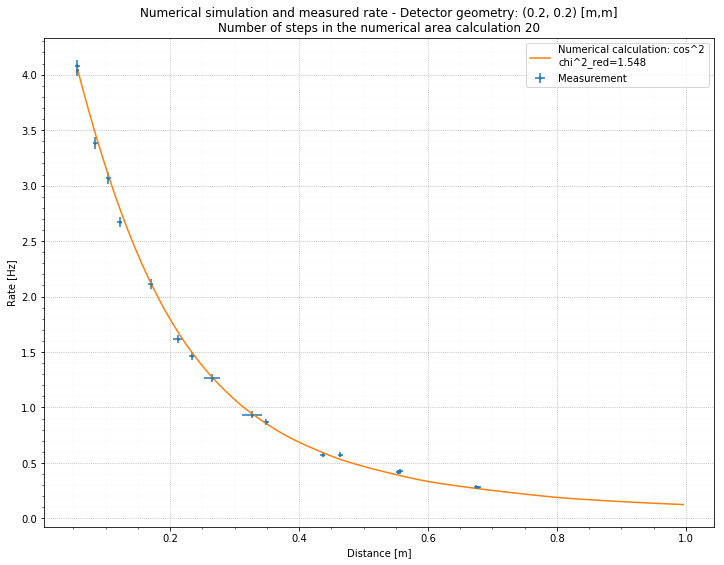

In [12]:
# create folder for the plot dump
directory = "plot_save/combined_num_data/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
             yerr=measured_data["d rate [Hz]"], fmt='.', xerr=measured_data["d distance [m]"],
             markersize=3, label="Measurement")
plt.plot(distance_range, acceptances, label="Numerical calculation: cos^2\nchi^2_red={:0.3f}".format(chi2_red))

plt.legend()
plt.grid(which='major', linestyle=':')
plt.grid(which='minor', linestyle=':', linewidth=0.1)
title = "Numerical simulation and measured rate - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
title += "Number of steps in the numerical area calculation {:.0f}".format(g_steps)
plt.title(title)
plt.xlabel("Distance [m]")
plt.ylabel("Rate [Hz]")
plt.savefig(directory+"num_sim_distrubution-{}_steps_in_calc_{}.png".format(chosen_distru, g_steps))
plt.show()

### Prepare for making some final plots

In [7]:
optimal_curves = {}

## Fit Biallass&Hebbeker with minuit

In [8]:
# itteratively solve the problem
num_optimization_runs = 5
g_steps = 500
chosen_distru = "Biallass&Hebbeker"
det = Numerically_simulated_detector(scintillator_slab_geometry, chosen_distru, g_steps)

iterated_norm = 1.

for run_number in range(num_optimization_runs):
    # create the dictionary to tell Minuit how to talk to the function
    kwargs = {}
    kwargs["forced_parameters"] = ('normierung',)
    for para in kwargs["forced_parameters"]:
        kwargs[para] = 1
        kwargs["error_" + para] = 0.1
        kwargs["limit_" + para] = (0.1, 1000.0)
    # setup minuit
    # only the norm can be changed here, so the rest stays 0
    func_for_optimization = lambda normierung: det.corrected_chi2_for_data(0,
                                                                              normierung,
                                                                              measured_data["distance [m]"],
                                                                              measured_data["rate [Hz]"],
                                                                              measured_data["d distance [m]"],
                                                                              0,
                                                                              iterated_norm)
    m = Minuit(func_for_optimization,
               errordef=1.0, print_level=0,
               **kwargs)
    
    # run minuit
    m.migrad()
    
    # set resulting parameters as iteration step
    iterated_norm = m.values['normierung']
    # print some stats
    msg = "Run #{}:\tCurrent parameters norm={:.5f}+-{:.5f}".format(run_number, m.values['normierung'], m.errors['normierung'])
    print(msg)
    

C:\Users\Hendrik\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\Hendrik\AppData\Local\conda\conda\envs\py27\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


Run #0:	Current parameters norm=4.00812+-0.01299
Run #1:	Current parameters norm=4.00553+-0.03403
Run #2:	Current parameters norm=4.00553+-0.03402
Run #3:	Current parameters norm=4.00553+-0.03402
Run #4:	Current parameters norm=4.00553+-0.03402


In [9]:
m.print_param()
print('parameters', m.parameters)
print('args', m.args)
print('value', m.values)
print('error', m.errors)

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,normierung,4.00553,0.0340157,0,0,0.1,1000.0,


('parameters', ('normierung',))
('args', (4.005533168160779,))
('value', {'normierung': 4.005533168160779})
('error', {'normierung': 0.03401566565941461})


In [10]:
# do the simulation
# generate ticks in the grid
theta_range = np.linspace(0, np.pi/2, g_steps)

# scan over a range of distances
distance_range = np.arange(0, 0.82, 0.02)
# add our normation point into the distance range
distance_range = np.insert(distance_range, np.argwhere((distance_range>minimum_distance))[0][0], minimum_distance)
acceptances = np.empty(len(distance_range))
for i in range(len(distance_range)):
    # calculate areas
    areas_dependent_on_theta = det.calculate_area_dependent_on_theta(theta_range, distance_range[i])
    # calculate acceptance
    acceptances[i] = det.calculate_acceptance(areas_dependent_on_theta, theta_range)
    if i % (len(distance_range)//10) == 0:
        print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

# norm rate
minimum_distance
acceptances /= acceptances[np.argwhere((distance_range==minimum_distance))[0][0]]
acceptances *= m.values['normierung']

# get the rate at 0 (e.g. the flux) and it's error
flux = acceptances[0]
flux_error = (m.errors['normierung']/acceptances[np.argwhere((distance_range==minimum_distance))[0][0]] ) * acceptances[0]

chi2 = func_for_optimization(m.values['normierung'])
chi2_red = chi2/(len(measured_data["distance [m]"])-1)

print('chi^2_red: %.15f' % chi2_red)
print('Flux: %.15f' % flux)

Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38.0 [%] 
Current progress: 47.0 [%] 
Current progress: 57.0 [%] 
Current progress: 66.0 [%] 
Current progress: 76.0 [%] 
Current progress: 85.0 [%] 
Current progress: 95.0 [%] 
chi^2_red: 0.776135286080762
Flux: 5.257441651046906


In [11]:
# save values
optimal_curves['BH'] = {
    'grid_steps': g_steps,
    'chi^2_red': chi2_red,
    'Flux': flux,
    'Flux_err': flux_error,
    'n': 0,
    'n_error': 0,
    'x': distance_range,
    'y': acceptances
}

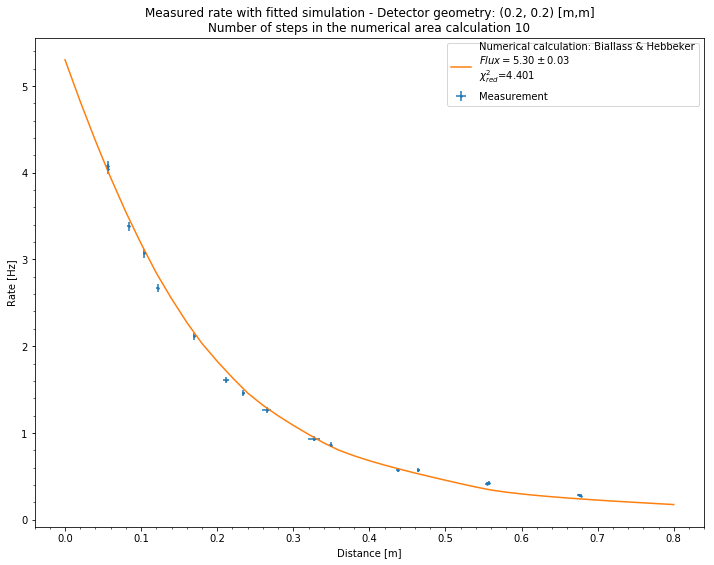

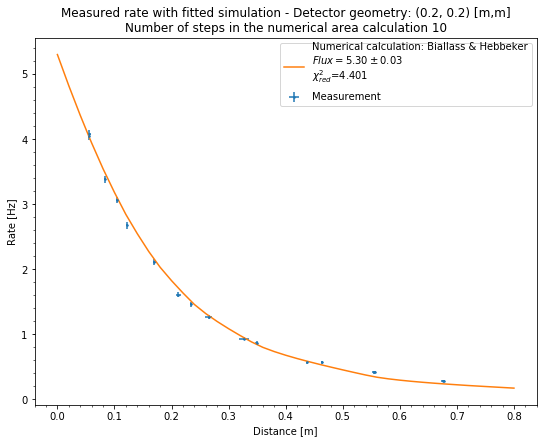

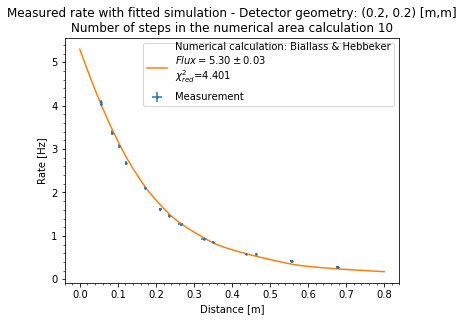

In [16]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot in different sizes
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")
    curve_label = 'Numerical calculation: Biallass & Hebbeker\n$Flux=%.2f\pm%.2f$\n$\chi^2_{red}$=%0.3f' % (flux, flux_error, chi2_red)
    plt.plot(distance_range, acceptances, label=curve_label)

    plt.legend()
    #plt.grid(which='major', linestyle=':')
    #plt.grid(which='minor', linestyle=':', linewidth=0.1)
    title = "Measured rate with fitted simulation - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
    title += "Number of steps in the numerical area calculation {:.0f}".format(g_steps)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    #plt.savefig(directory+"size_{}_fitted_distru-{}_steps_in_calc_{}.pdf".format(size_factor, chosen_distru, g_steps))
    plt.show()

## Fit cos^n to measured data with minuit

In [12]:
# itteratively solve the problem
num_optimization_runs = 5
g_steps = 500
chosen_distru = "Cos^n"
det = Numerically_simulated_detector(scintillator_slab_geometry, chosen_distru, g_steps)

iterated_n, iterated_norm = 1., 1.

for run_number in range(num_optimization_runs):
    # create the dictionary to tell Minuit how to talk to the function
    kwargs = {}
    kwargs["forced_parameters"] = ('n', 'normierung')
    for para in kwargs["forced_parameters"]:
        kwargs[para] = 1
        kwargs["error_" + para] = 0.1
        kwargs["limit_" + para] = (0.1, 1000.0)
    
    # setup minuit
    func_for_optimization = lambda n, normierung: det.corrected_chi2_for_data(n,
                                                                              normierung,
                                                                              measured_data["distance [m]"],
                                                                              measured_data["rate [Hz]"],
                                                                              measured_data["d distance [m]"],
                                                                              iterated_n,
                                                                              iterated_norm)
    m = Minuit(func_for_optimization,
               errordef=1.0, print_level=0,
               **kwargs)
    
    # run minuit
    m.migrad()
    
    # set resulting parameters as iteration step
    iterated_n, iterated_norm = m.values['n'], m.values['normierung']
    # print some stats
    msg = "Run #{}:\tCurrent parameters n={:.5f}+-{:.5f}, norm={:.5f}+-{:.5f}".format(run_number, m.values['n'], m.errors['n'], m.values['normierung'], m.errors['normierung'])
    print(msg)
    

Run #0:	Current parameters n=2.07759+-0.05118, norm=4.07496+-0.01934
Run #1:	Current parameters n=2.13038+-0.13822, norm=4.07000+-0.05720
Run #2:	Current parameters n=2.12938+-0.13858, norm=4.07072+-0.05732
Run #3:	Current parameters n=2.12939+-0.13859, norm=4.07071+-0.05733
Run #4:	Current parameters n=2.12939+-0.13859, norm=4.07071+-0.05733


In [13]:
m.print_param()
print('parameters', m.parameters)
print('args', m.args)
print('value', m.values)
print('error', m.errors)

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,n,2.12939,0.138586,0,0,0.1,1000.0,
2,normierung,4.07071,0.0573281,0,0,0.1,1000.0,


('parameters', ('n', 'normierung'))
('args', (2.1293899114295627, 4.070711029601028))
('value', {'normierung': 4.070711029601028, 'n': 2.1293899114295627})
('error', {'normierung': 0.057328125571945776, 'n': 0.13858582657682172})


In [14]:
det._additional_angle_distributions_parameters = {'n': m.values['n']}

# do the simulation
# generate ticks in the grid
theta_range = np.linspace(0, np.pi/2, g_steps)

# scan over a range of distances
distance_range = np.arange(0, 0.82, 0.02)
# add our normation point into the distance range
distance_range = np.insert(distance_range, np.argwhere((distance_range>minimum_distance))[0][0], minimum_distance)
acceptances = np.empty(len(distance_range))
for i in range(len(distance_range)):
    # calculate areas
    areas_dependent_on_theta = det.calculate_area_dependent_on_theta(theta_range, distance_range[i])
    # calculate acceptance
    acceptances[i] = det.calculate_acceptance(areas_dependent_on_theta, theta_range)
    if i % (len(distance_range)//10) == 0:
        print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

# norm rate
minimum_distance
acceptances /= acceptances[np.argwhere((distance_range==minimum_distance))[0][0]]
acceptances *= m.values['normierung']

# get the rate at 0 (e.g. the flux) and it's error
flux = acceptances[0]
flux_error = (m.errors['normierung']/acceptances[np.argwhere((distance_range==minimum_distance))[0][0]] ) * acceptances[0]

chi2 = func_for_optimization(m.values['n'], m.values['normierung'])
chi2_red = chi2/(len(measured_data["distance [m]"])-2)

det._additional_angle_distributions_parameters = {}

print('Chi^2_red: %.15f' % chi2_red)
print('n: %.15f' % m.values['n'])
print('Flux: %.15f' % flux)

Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38.0 [%] 
Current progress: 47.0 [%] 
Current progress: 57.0 [%] 
Current progress: 66.0 [%] 
Current progress: 76.0 [%] 
Current progress: 85.0 [%] 
Current progress: 95.0 [%] 
Chi^2_red: 0.625492690357611
n: 2.129389911429563
Flux: 5.423819797358854


In [15]:
# save values
optimal_curves['cos^n'] = {
    'grid_steps': g_steps,
    'chi^2_red': chi2_red,
    'Flux': flux,
    'Flux_err': flux_error,
    'n': m.values['n'],
    'n_error': m.errors['n'],
    'x': distance_range,
    'y': acceptances
}

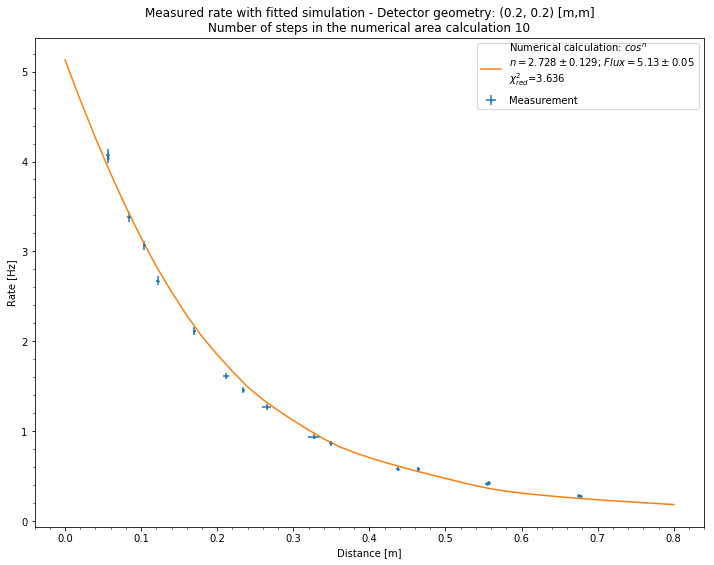

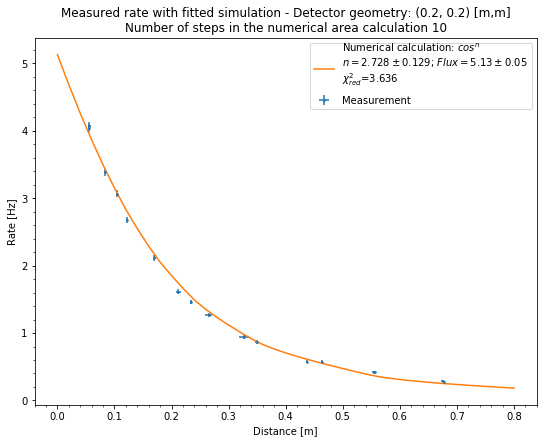

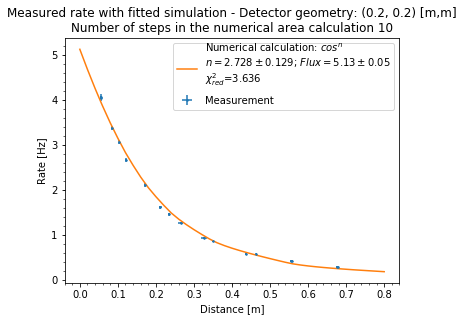

In [21]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

# create plot in different sizes
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")
    curve_label = 'Numerical calculation: $cos^n$\n$n=%.3f\pm%.3f$; $Flux=%.2f\pm%.2f$\n$\chi^2_{red}$=%0.3f' % (m.values['n'], m.errors['n'], flux, flux_error, chi2_red)
    plt.plot(distance_range, acceptances, label=curve_label)

    plt.legend()
    #plt.grid(which='major', linestyle=':')
    #plt.grid(which='minor', linestyle=':', linewidth=0.1)
    title = "Measured rate with fitted simulation - Detector geometry: {0} [m,m]\n".format(scintillator_slab_geometry)
    title += "Number of steps in the numerical area calculation {:.0f}".format(g_steps)
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    #plt.savefig(directory+"size_{}_fitted_distru-{}_steps_in_calc_{}.pdf".format(size_factor, chosen_distru, g_steps))
    plt.show()

## Fixed n in cos^n

In [16]:
# itteratively solve the problem
num_optimization_runs = 5
g_steps = 500
chosen_distru = "Cos^n"
n_to_simulate = [1., 2., 3.]

for curr_n in n_to_simulate:

    det = Numerically_simulated_detector(scintillator_slab_geometry, chosen_distru, g_steps)
    iterated_n, iterated_norm = curr_n, 1.

    for run_number in range(num_optimization_runs):
        # create the dictionary to tell Minuit how to talk to the function
        kwargs = {}
        kwargs["forced_parameters"] = ('normierung',)
        for para in kwargs["forced_parameters"]:
            kwargs[para] = 1
            kwargs["error_" + para] = 0.1
            kwargs["limit_" + para] = (0.1, 1000.0)

        # setup minuit
        func_for_optimization = lambda normierung: det.corrected_chi2_for_data(iterated_n,
                                                                                  normierung,
                                                                                  measured_data["distance [m]"],
                                                                                  measured_data["rate [Hz]"],
                                                                                  measured_data["d distance [m]"],
                                                                                  iterated_n,
                                                                                  iterated_norm)
        m = Minuit(func_for_optimization,
                   errordef=1.0, print_level=0,
                   **kwargs)

        # run minuit
        m.migrad()

        # set resulting parameters as iteration step
        iterated_norm = m.values['normierung']
        # print some stats
        msg = "Run #{}:\tCurrent parameters norm={:.5f}+-{:.5f}".format(run_number, m.values['normierung'], m.errors['normierung'])
        print(msg)

    # calculate values for plotting
    det._additional_angle_distributions_parameters = {'n': iterated_n}

    # do the simulation
    # generate ticks in the grid
    theta_range = np.linspace(0, np.pi/2, g_steps)

    # scan over a range of distances
    distance_range = np.arange(0, 0.82, 0.02)
    # add our normation point into the distance range
    distance_range = np.insert(distance_range, np.argwhere((distance_range>minimum_distance))[0][0], minimum_distance)
    acceptances = np.empty(len(distance_range))
    for i in range(len(distance_range)):
        # calculate areas
        areas_dependent_on_theta = det.calculate_area_dependent_on_theta(theta_range, distance_range[i])
        # calculate acceptance
        acceptances[i] = det.calculate_acceptance(areas_dependent_on_theta, theta_range)
        if i % (len(distance_range)//10) == 0:
            print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

    # norm rate
    minimum_distance
    acceptances /= acceptances[np.argwhere((distance_range==minimum_distance))[0][0]]
    acceptances *= m.values['normierung']

    # get the rate at 0 (e.g. the flux) and it's error
    flux = acceptances[0]
    flux_error = (m.errors['normierung']/acceptances[np.argwhere((distance_range==minimum_distance))[0][0]] ) * acceptances[0]

    chi2 = func_for_optimization(m.values['normierung'])
    chi2_red = chi2/(len(measured_data["distance [m]"])-1)

    det._additional_angle_distributions_parameters = {}

    print('Chi^2_red: %.15f' % chi2_red)
    print('n: %.15f' % iterated_n)
    print('Flux: %.15f' % flux)

    # save values
    optimal_curves['cos^'+str(iterated_n)] = {
        'grid_steps': g_steps,
        'chi^2_red': chi2_red,
        'Flux': flux,
        'Flux_err': flux_error,
        'n': iterated_n,
        'n_error': 0,
        'x': distance_range,
        'y': acceptances
    }

Run #0:	Current parameters norm=4.42010+-0.01341
Run #1:	Current parameters norm=4.49273+-0.03719
Run #2:	Current parameters norm=4.49396+-0.03765
Run #3:	Current parameters norm=4.49398+-0.03765
Run #4:	Current parameters norm=4.49398+-0.03765
Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38.0 [%] 
Current progress: 47.0 [%] 
Current progress: 57.0 [%] 
Current progress: 66.0 [%] 
Current progress: 76.0 [%] 
Current progress: 85.0 [%] 
Current progress: 95.0 [%] 
Chi^2_red: 6.194879757051896
n: 1.000000000000000
Flux: 6.490191089877851
Run #0:	Current parameters norm=4.09920+-0.01329
Run #1:	Current parameters norm=4.11261+-0.03578
Run #2:	Current parameters norm=4.11266+-0.03587
Run #3:	Current parameters norm=4.11266+-0.03587
Run #4:	Current parameters norm=4.11266+-0.03587
Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38

In [17]:
# save data to disk

# first the plots comparing BH and cos^n
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

save_result_dont_import = True
if save_result_dont_import:
    with open(directory+"optimal_curves.pkl", "wb") as f:
        pickle.dump(optimal_curves, f)
else:
    with open(directory+"optimal_curves.pkl", "rb") as f:
        optimal_curves = pickle.load(f)

## Plot the final plots from the optimal_curves

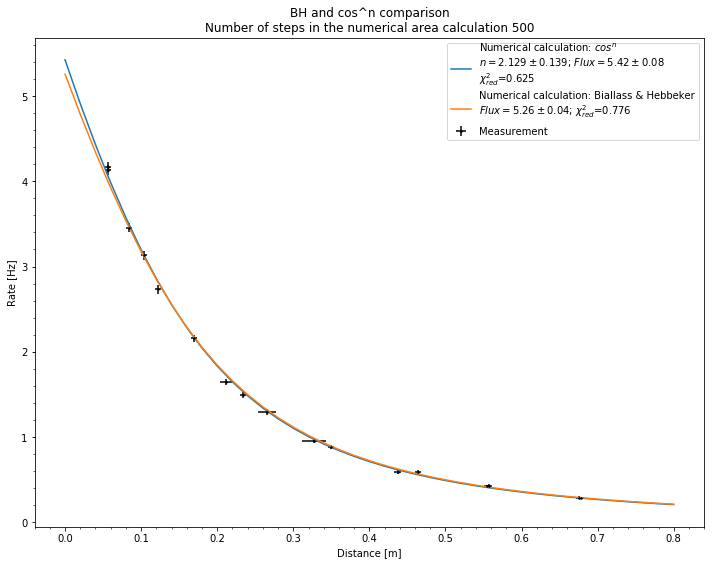

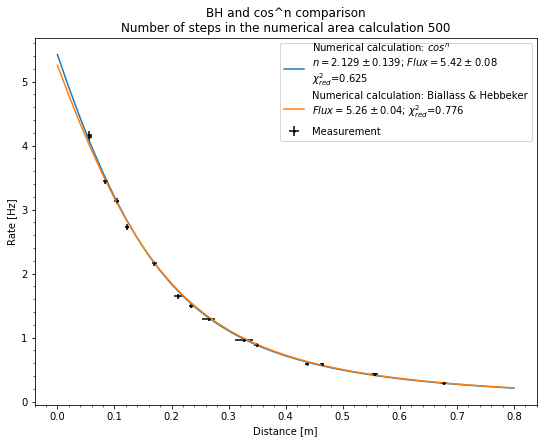

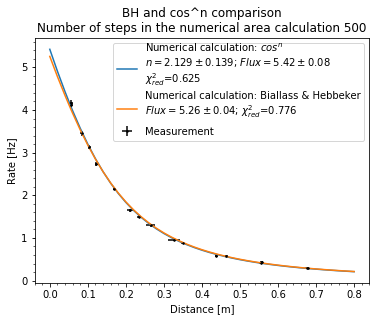

In [18]:
# create plot in different sizes
for size_factor in (1., .75, .5):
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    curve_label = 'Numerical calculation: $cos^n$\n$n=%.3f\pm%.3f$; $Flux=%.2f\pm%.2f$\n$\chi^2_{red}$=%0.3f' % (optimal_curves['cos^n']['n'], optimal_curves['cos^n']['n_error'], optimal_curves['cos^n']['Flux'], optimal_curves['cos^n']['Flux_err'], optimal_curves['cos^n']['chi^2_red'])
    plt.plot(optimal_curves['cos^n']['x'], optimal_curves['cos^n']['y'], label=curve_label)
    
    curve_label = 'Numerical calculation: Biallass & Hebbeker\n$Flux=%.2f\pm%.2f$; $\chi^2_{red}$=%0.3f' % (optimal_curves['BH']['Flux'], optimal_curves['BH']['Flux_err'], optimal_curves['BH']['chi^2_red'])
    plt.plot(optimal_curves['BH']['x'], optimal_curves['BH']['y'], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")
    plt.legend()
    #plt.grid(which='major', linestyle=':')
    #plt.grid(which='minor', linestyle=':', linewidth=0.1)
    title = "BH and cos^n comparison\n".format()
    title += "Number of steps in the numerical area calculation {:.0f}".format(optimal_curves['BH']['grid_steps'])
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"size_{}_BH_cos2_comparison_steps_in_calc_{}.pdf".format(size_factor, optimal_curves['BH']['grid_steps']))
    plt.show()

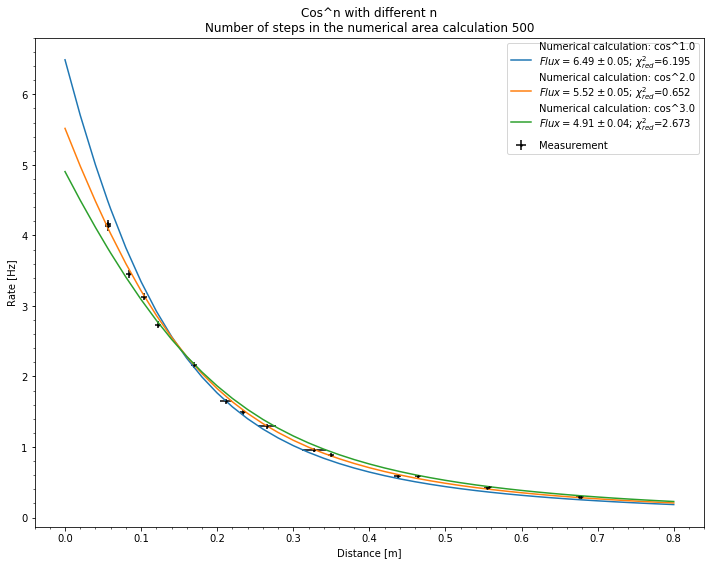

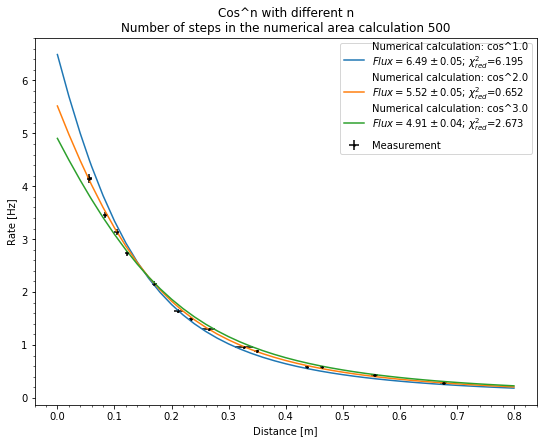

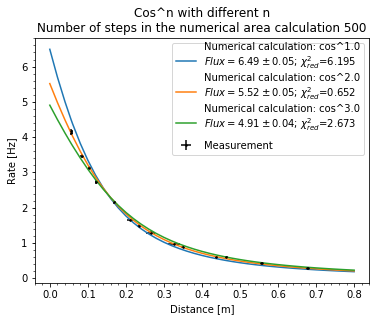

In [19]:
for size_factor in (1., .75, .5):

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    keys = sorted(optimal_curves.keys())
    for key in keys:
        if "." not in key:
            continue
        curve_label = 'Numerical calculation: %s\n$Flux=%.2f\pm%.2f$; $\chi^2_{red}$=%0.3f' % (key, optimal_curves[key]['Flux'], optimal_curves[key]['Flux_err'], optimal_curves[key]['chi^2_red'])
        plt.plot(optimal_curves[key]['x'], optimal_curves[key]['y'], label=curve_label)
    
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")
    plt.legend()
    title = "Cos^n with different n\n".format()
    title += "Number of steps in the numerical area calculation {:.0f}".format(optimal_curves['BH']['grid_steps'])
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    plt.savefig(directory+"size_{}_cosn_differnt_n_steps_in_calc_{}.pdf".format(size_factor, optimal_curves['BH']['grid_steps']))
    plt.show()

## Simulate for different number of grid steps

In [42]:
grid_curves = {}

In [43]:
# itteratively solve the problem
num_optimization_runs = 5
chosen_distru = "Cos^n"
g_steps_to_sim = np.logspace(1, 3.7, num=13, dtype=np.int)

for g_steps in g_steps_to_sim: 
    print("current grid steps: ", g_steps)

    det = Numerically_simulated_detector(scintillator_slab_geometry, chosen_distru, g_steps)
    iterated_n, iterated_norm = 1., 1.

    for run_number in range(num_optimization_runs):
        # create the dictionary to tell Minuit how to talk to the function
        kwargs = {}
        kwargs["forced_parameters"] = ('n', 'normierung')
        for para in kwargs["forced_parameters"]:
            kwargs[para] = 1
            kwargs["error_" + para] = 0.1
            kwargs["limit_" + para] = (0.1, 1000.0)

        # setup minuit
        func_for_optimization = lambda n, normierung: det.corrected_chi2_for_data(n,
                                                                                  normierung,
                                                                                  measured_data["distance [m]"],
                                                                                  measured_data["rate [Hz]"],
                                                                                  measured_data["d distance [m]"],
                                                                                  iterated_n,
                                                                                  iterated_norm)
        m = Minuit(func_for_optimization,
                   errordef=1.0, print_level=0,
                   **kwargs)

        # run minuit
        m.migrad()

        # set resulting parameters as iteration step
        iterated_n, iterated_norm = m.values['n'], m.values['normierung']
        # print some stats
        msg = "Run #{}:\tCurrent parameters n={:.5f}+-{:.5f}, norm={:.5f}+-{:.5f}".format(run_number, m.values['n'], m.errors['n'], m.values['normierung'], m.errors['normierung'])
        print(msg)

    det._additional_angle_distributions_parameters = {'n': m.values['n']}

    # do the simulation
    # generate ticks in the grid
    theta_range = np.linspace(0, np.pi/2, g_steps)

    # scan over a range of distances
    distance_range = np.arange(0, 0.82, 0.02)
    # add our normation point into the distance range
    distance_range = np.insert(distance_range, np.argwhere((distance_range>minimum_distance))[0][0], minimum_distance)
    acceptances = np.empty(len(distance_range))
    for i in range(len(distance_range)):
        # calculate areas
        areas_dependent_on_theta = det.calculate_area_dependent_on_theta(theta_range, distance_range[i])
        # calculate acceptance
        acceptances[i] = det.calculate_acceptance(areas_dependent_on_theta, theta_range)
        if i % (len(distance_range)//10) == 0:
            print("Current progress: {:.1f} [%] ".format(i*100/len(distance_range)))

    # norm rate
    minimum_distance
    acceptances /= acceptances[np.argwhere((distance_range==minimum_distance))[0][0]]
    acceptances *= m.values['normierung']

    # get the rate at 0 (e.g. the flux) and it's error
    flux = acceptances[0]
    flux_error = (m.errors['normierung']/acceptances[np.argwhere((distance_range==minimum_distance))[0][0]] ) * acceptances[0]

    chi2 = func_for_optimization(m.values['n'], m.values['normierung'])
    chi2_red = chi2/(len(measured_data["distance [m]"])-2)

    det._additional_angle_distributions_parameters = {}

    print('Chi^2_red: %.15f' % chi2_red)
    print('n: %.15f' % m.values['n'])
    print('Flux: %.15f' % flux)

    # save values
    grid_curves[g_steps] = {
        'chi^2_red': chi2_red,
        'Flux': flux,
        'Flux_err': flux_error,
        'n': m.values['n'],
        'n_error': m.errors['n'],
        'x': distance_range,
        'y': acceptances
    }


('current grid steps: ', 10)
Run #0:	Current parameters n=2.79618+-0.06035, norm=3.91202+-0.01904
Run #1:	Current parameters n=2.95247+-0.16973, norm=3.90753+-0.05686
Run #2:	Current parameters n=2.94986+-0.17109, norm=3.91004+-0.05724
Run #3:	Current parameters n=2.94987+-0.17114, norm=3.91001+-0.05727
Run #4:	Current parameters n=2.94987+-0.17114, norm=3.91001+-0.05727
Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38.0 [%] 
Current progress: 47.0 [%] 
Current progress: 57.0 [%] 
Current progress: 66.0 [%] 
Current progress: 76.0 [%] 
Current progress: 85.0 [%] 
Current progress: 95.0 [%] 
Chi^2_red: 2.433408553272941
n: 2.949871582189922
Flux: 5.045937520956909
('current grid steps: ', 16)
Run #0:	Current parameters n=2.29509+-0.05437, norm=3.96541+-0.01924
Run #1:	Current parameters n=2.37439+-0.14898, norm=3.95966+-0.05652
Run #2:	Current parameters n=2.37304+-0.14959, norm=3.96056+-0.05670
Run #3:	Cu

Current progress: 95.0 [%] 
Chi^2_red: 0.621168694819061
n: 2.125652344473767
Flux: 5.311040966862417
('current grid steps: ', 2985)
Run #0:	Current parameters n=2.07342+-0.05165, norm=3.98992+-0.01933
Run #1:	Current parameters n=2.12668+-0.13827, norm=3.98492+-0.05620
Run #2:	Current parameters n=2.12614+-0.13864, norm=3.98533+-0.05632
Run #3:	Current parameters n=2.12615+-0.13865, norm=3.98533+-0.05632
Run #4:	Current parameters n=2.12615+-0.13865, norm=3.98533+-0.05632
Current progress: 0.0 [%] 
Current progress: 9.0 [%] 
Current progress: 19.0 [%] 
Current progress: 28.0 [%] 
Current progress: 38.0 [%] 
Current progress: 47.0 [%] 
Current progress: 57.0 [%] 
Current progress: 66.0 [%] 
Current progress: 76.0 [%] 
Current progress: 85.0 [%] 
Current progress: 95.0 [%] 
Chi^2_red: 0.622323830983956
n: 2.126151238511100
Flux: 5.310942879123004
('current grid steps: ', 5011)
Run #0:	Current parameters n=2.07317+-0.05165, norm=3.98995+-0.01933
Run #1:	Current parameters n=2.12588+-0.13

In [6]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)
    
save_result_dont_import = False
if save_result_dont_import:
    with open(directory+"grid_curves.pkl", "wb") as f:
        pickle.dump(grid_curves, f)
else:
    with open(directory+"grid_curves.pkl", "rb") as f:
        grid_curves = pickle.load(f)

In [7]:
grid_curves

{10: {'Flux': 5.0459375209569091,
  'Flux_err': 0.07390389481868756,
  'chi^2_red': 2.4334085532729413,
  'n': 2.949871582189922,
  'n_error': 0.171139328600028,
  'x': array([ 0.   ,  0.02 ,  0.04 ,  0.056,  0.06 ,  0.08 ,  0.1  ,  0.12 ,
          0.14 ,  0.16 ,  0.18 ,  0.2  ,  0.22 ,  0.24 ,  0.26 ,  0.28 ,
          0.3  ,  0.32 ,  0.34 ,  0.36 ,  0.38 ,  0.4  ,  0.42 ,  0.44 ,
          0.46 ,  0.48 ,  0.5  ,  0.52 ,  0.54 ,  0.56 ,  0.58 ,  0.6  ,
          0.62 ,  0.64 ,  0.66 ,  0.68 ,  0.7  ,  0.72 ,  0.74 ,  0.76 ,
          0.78 ,  0.8  ]),
  'y': array([ 5.04593752,  4.62005837,  4.21642874,  3.91000885,  3.83553174,
          3.47762352,  3.14623492,  2.83605179,  2.55965356,  2.30237493,
          2.07089613,  1.87123522,  1.68639184,  1.51302332,  1.37267468,
          1.25051177,  1.1384082 ,  1.03297377,  0.93268   ,  0.84641954,
          0.7794634 ,  0.72109974,  0.66821522,  0.61912817,  0.57248662,
          0.52831426,  0.48528086,  0.44338639,  0.40263088,  0.36

In [8]:
keys = sorted(grid_curves.keys())

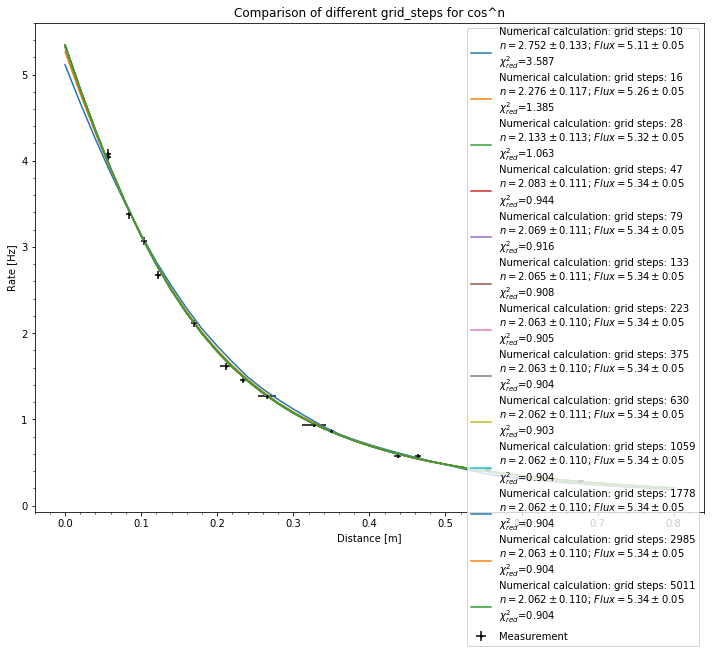

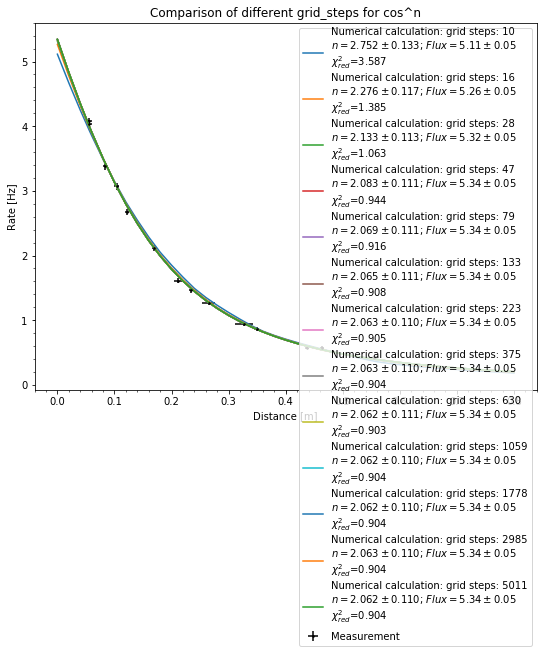

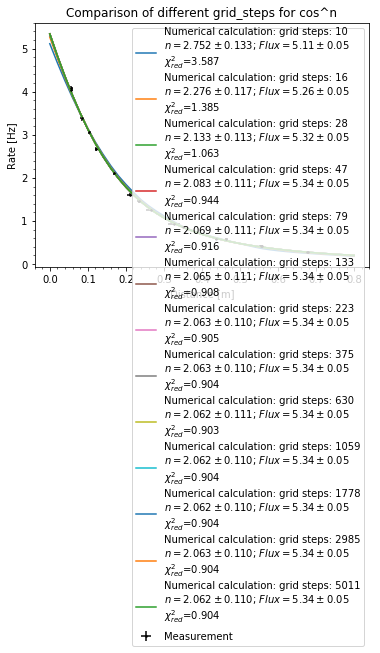

In [64]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

for size_factor in (1., .75, .5):

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    for key in keys:
        curve_label = 'Numerical calculation: grid steps: %d\n$n=%.3f\pm%.3f$; $Flux=%.2f\pm%.2f$\n$\chi^2_{red}$=%0.3f' % (key, grid_curves[key]['n'], grid_curves[key]['n_error'], grid_curves[key]['Flux'], grid_curves[key]['Flux_err'], grid_curves[key]['chi^2_red'])
        plt.plot(grid_curves[key]['x'], grid_curves[key]['y'], label=curve_label)
    plt.errorbar(measured_data["distance [m]"], measured_data["rate [Hz]"],
                 yerr=measured_data["d rate [Hz]"], fmt='.k', xerr=measured_data["d distance [m]"],
                 markersize=3, label="Measurement")

    plt.legend()
    title = "Comparison of different grid_steps for cos^n"
    plt.title(title)
    plt.xlabel("Distance [m]")
    plt.ylabel("Rate [Hz]")
    #plt.savefig(directory+"size_{}_different_steps_in_calc.pdf".format(size_factor))
    plt.show()

In [9]:
n_over_keys = []
flux_over_keys = []
chi2_over_keys = []

for key in keys:
    n_over_keys.append([grid_curves[key]['n'], grid_curves[key]['n_error']])
    flux_over_keys.append([grid_curves[key]['Flux'], grid_curves[key]['Flux_err']])
    chi2_over_keys.append(grid_curves[key]['chi^2_red'])

n_over_keys = np.asarray(n_over_keys)
flux_over_keys = np.asarray(flux_over_keys)
chi2_over_keys = np.asarray(chi2_over_keys)

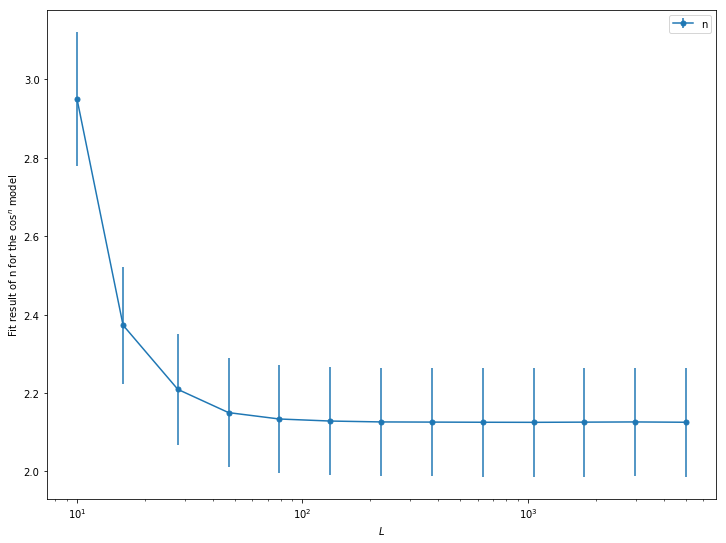

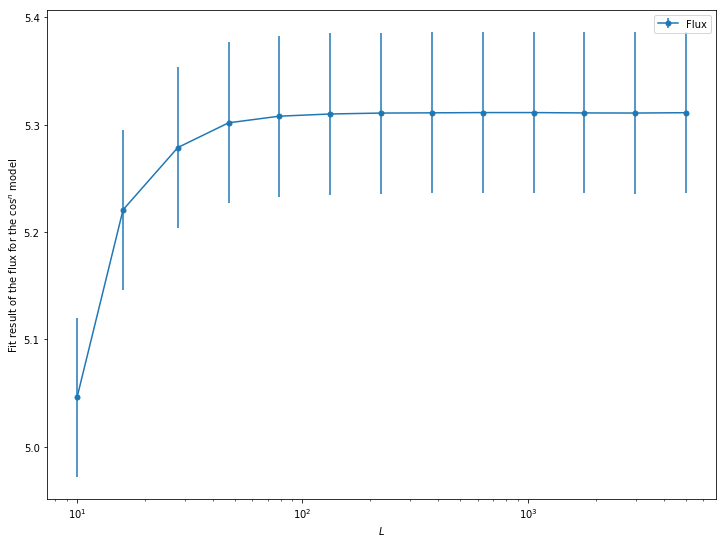

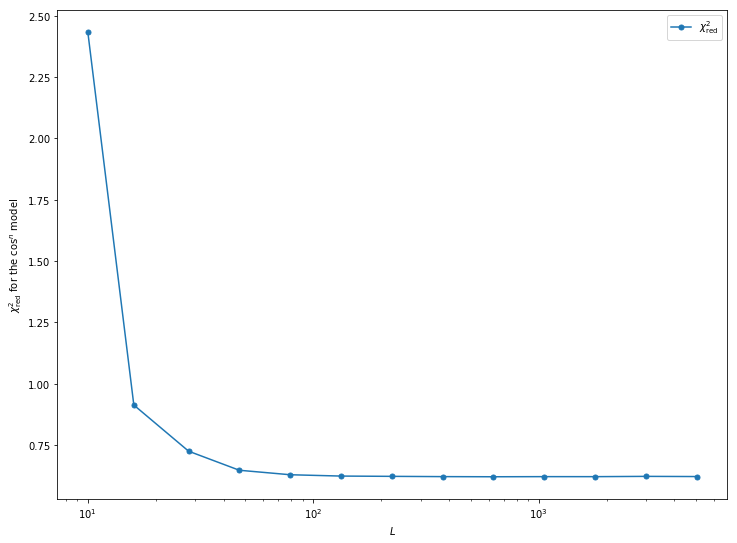

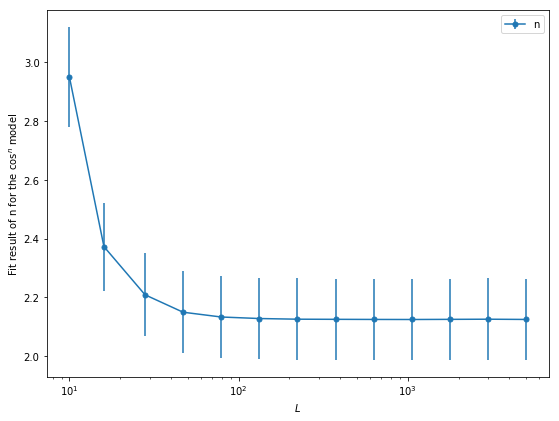

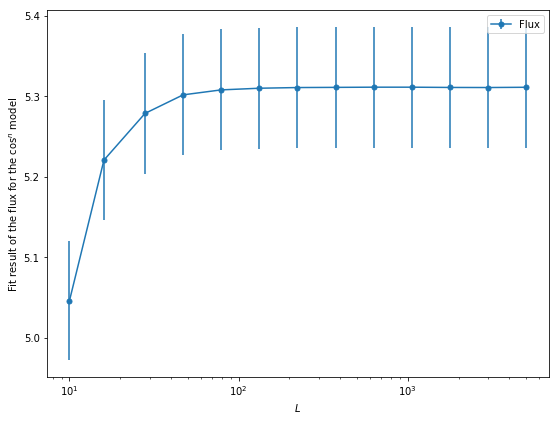

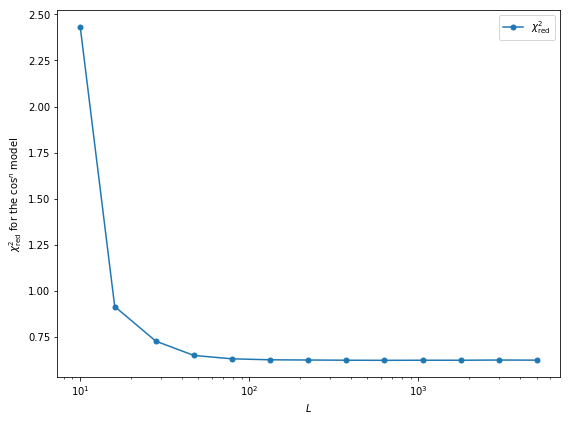

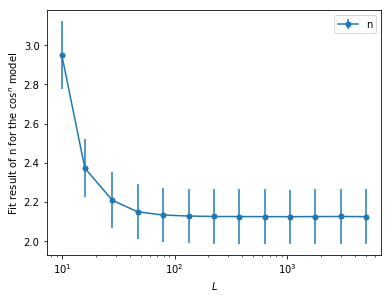

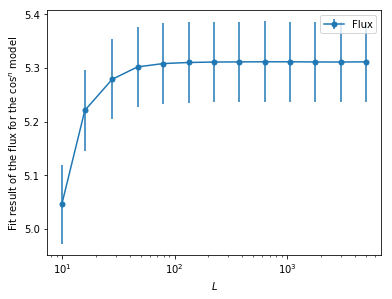

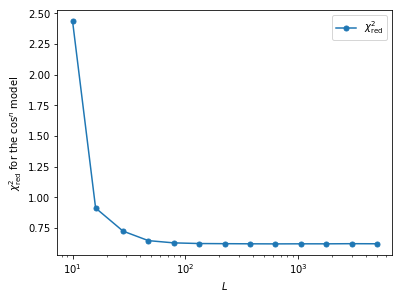

In [12]:
markersize = 5
for size_factor in (1., .75, .5):

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    n_normer = n_over_keys[...,0][len(n_over_keys[...,0])-1]
    n_normer = 1
    plt.errorbar(keys, (n_over_keys[...,0]/n_normer),
                     yerr=n_over_keys[...,1]/n_normer, fmt='o-',
                     markersize=markersize, label="n")
    plt.xscale('log')
    plt.legend()
    plt.xlabel("$L$")
    plt.ylabel(r'Fit result of n for the $\cos^n$ model')
    plt.savefig(directory+"size_{}_different_steps_in_calc_change_n.pdf".format(size_factor))
    plt.show()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    flux_normer = flux_over_keys[...,0][len(flux_over_keys[...,0])-1]
    flux_normer = 1
    plt.errorbar(keys, (flux_over_keys[...,0]/flux_normer),
                     yerr=flux_over_keys[...,1]/flux_normer, fmt='o-',
                     markersize=markersize, label="Flux")
    plt.xscale('log')
    plt.legend()
    plt.xlabel("$L$")
    plt.ylabel(r'Fit result of the flux for the $\cos^n$ model')
    plt.savefig(directory+"size_{}_different_steps_in_calc_change_flux.pdf".format(size_factor))
    plt.show()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)
    plt.errorbar(keys, chi2_over_keys,
                 fmt='o-',
                 markersize=markersize, label=r'$\chi^2_{\rm red}$')
    plt.xscale('log')
    #plt.yscale('log')
    plt.legend()
    plt.xlabel("$L$")
    plt.ylabel(r'$\chi^2_{\rm red}$ for the $\cos^n$ model')
    plt.savefig(directory+"size_{}_different_steps_in_calc_change_chi2.pdf".format(size_factor))
    plt.show()

## Plot how the angular distributions actually look

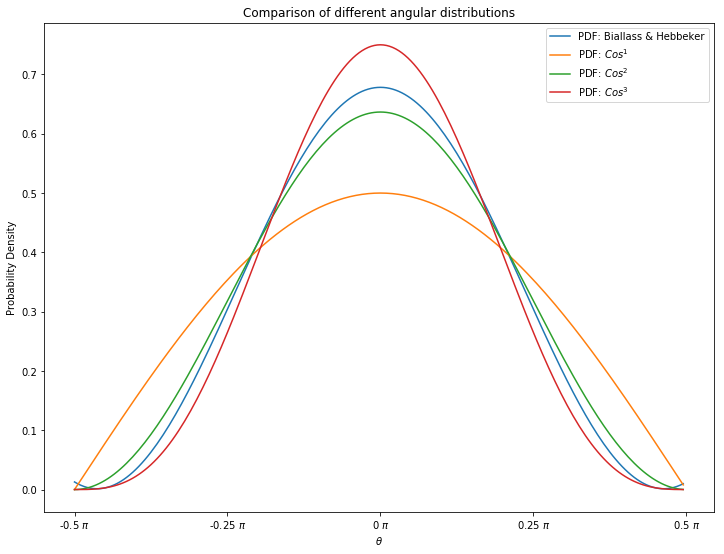

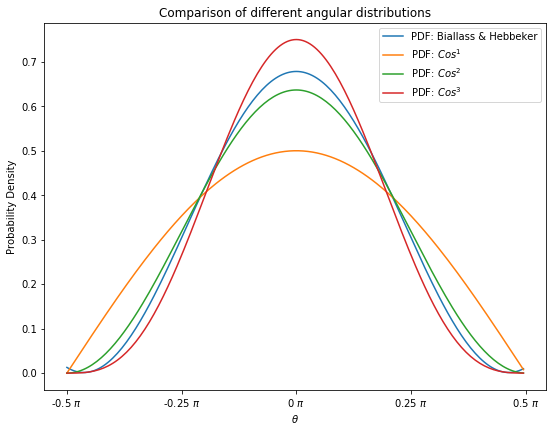

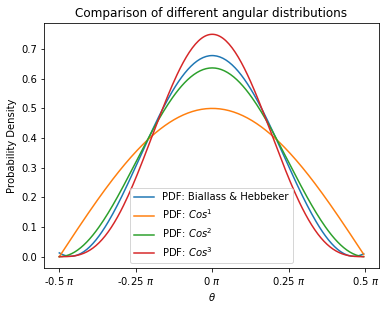

In [9]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

# compare available gnerators
num_bins = 100
x_points_to_plot = np.arange(-1./2., 1./2., 0.5/num_bins)

for size_factor in (1., .75, .5):

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=.25))
    
    norm_factor = quad(lambda x: available_angle_distributions['Biallass&Hebbeker'](x), -np.pi/2., np.pi/2.)[0]
    plt.plot(x_points_to_plot, available_angle_distributions['Biallass&Hebbeker'](x_points_to_plot*np.pi)/norm_factor, label="PDF: Biallass & Hebbeker")
    for i in [1.,2.,3.]:
        norm_factor = quad(lambda x: available_angle_distributions['Cos^n'](x, n=i), -np.pi/2., np.pi/2.)[0]
        plt.plot(x_points_to_plot, available_angle_distributions['Cos^n'](x_points_to_plot*np.pi, n=i)/norm_factor, label=r'PDF: $Cos^{:.0f}$'.format(i))

    title = "Comparison of different angular distributions"
    plt.title(title)
    plt.legend()
    plt.xlabel(r'$\theta$')
    plt.ylabel("Probability Density")
    plt.savefig(directory+"size_{}_different_angle_generators.pdf".format(size_factor))
    plt.show()

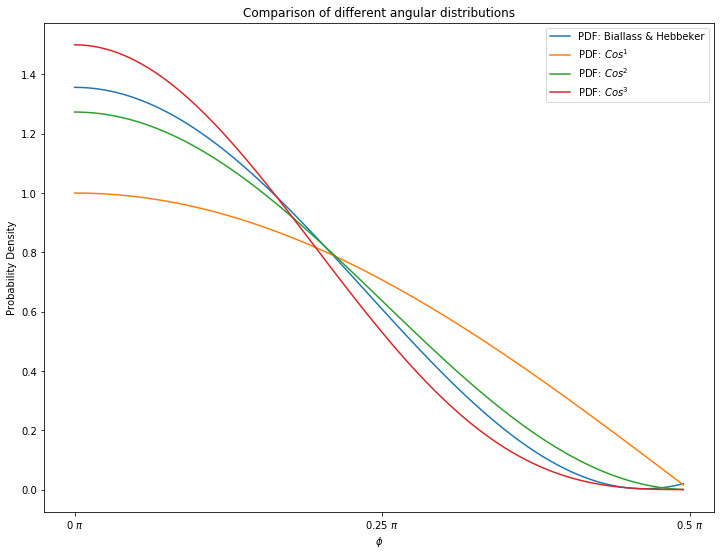

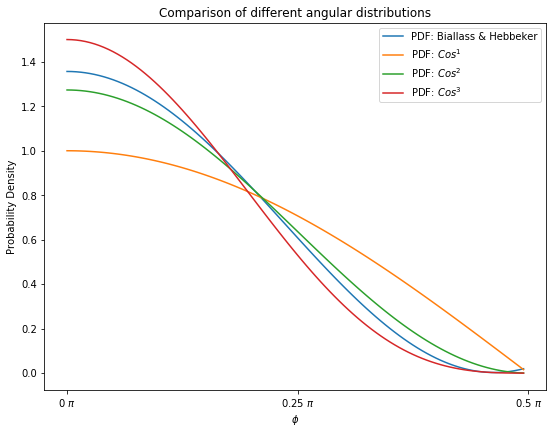

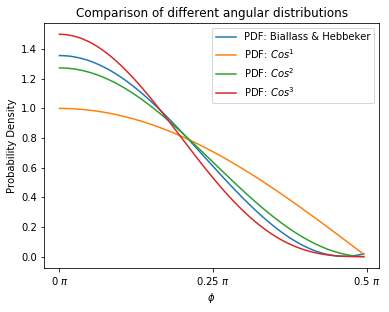

In [52]:
# create folder for the plot dump
directory = "plot_save/thesis_plots/"
if not os.path.exists(directory):
    os.makedirs(directory)

# compare available gnerators
num_bins = 100
x_points_to_plot = np.arange(0, 1./2., 0.5/num_bins)

for size_factor in (1., .75, .5):

    fig, ax = plt.subplots()
    fig.set_size_inches(size_factor*9*4./3., size_factor*9)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=.25))
    
    norm_factor = quad(lambda x: available_angle_distributions['Biallass&Hebbeker'](x), 0, np.pi/2.)[0]
    plt.plot(x_points_to_plot, available_angle_distributions['Biallass&Hebbeker'](x_points_to_plot*np.pi)/norm_factor, label="PDF: Biallass & Hebbeker")
    for i in [1.,2.,3.]:
        norm_factor = quad(lambda x: available_angle_distributions['Cos^n'](x, n=i), 0, np.pi/2.)[0]
        plt.plot(x_points_to_plot, available_angle_distributions['Cos^n'](x_points_to_plot*np.pi, n=i)/norm_factor, label=r'PDF: $Cos^{:.0f}$'.format(i))
    
    title = "Comparison of different angular distributions"
    plt.title(title)
    plt.legend()
    plt.xlabel("$\phi$")
    plt.ylabel("Probability Density")
    plt.savefig(directory+"size_{}_different_angle_generators_halved.pdf".format(size_factor))
    plt.show()